# DEC Supervised Learning + Clustering

This notebook focuses on using clustering after DEC has been trained using supervised learning over some examples and then doing the cluster training. The steps would be as follows:

 * Autoencoder Training
 * Supervised Learning
 * Clustering

### Importing required Libaries

Importing the required libraries and modules so that they can be used in the notebook

In [1]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
# loading the requirements for the Xception model
from keras.applications.xception import Xception
from keras.applications.xception import absolute_import, decode_predictions, preprocess_input
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
# Loading the DEC module cloned from github
from DEC.model import *
from DEC.metrics import *
from xception_dec_datagenerator import XceptionDataGenerator
# Importing the utilities
from utils.file_utils import *
from PIL import Image
# Using scikit-image  resize function for resizing the image from original size to 224 X 224
# from skimage.transform import resize
# Train Test split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from shutil import copy2
# For visualization of images and for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Xception Model

First we load the Xception model into the computer memory using the Keras library. Because we are focusing on extracting features from the model we do not include the topmost layer. However we do use the imagenet weights for the model. Also because we want a 1-D vector form of the features we do use the pooling layer at the end.

In [3]:
input_tensor_shape = (150, 150, 3)
base_xception_model = Xception(weights = 'imagenet', input_shape = input_tensor_shape, include_top = False, pooling='avg')
base_xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

The input shape of our base xception model is: 150 X 150 X 3. That is a 3 channel square image with side 150 pixels.
The output shape of the base xception model is: 2048 X 1. It is a 1-D vector representing the features learned by the model

### Loading the Galaxy Zoo data

We now start loading the galaxy zoo data into memory. First we load the label file and then start loading the corresponding images such that we can assign the corresponding label to them

In [4]:
all_labels = pd.read_csv(f'../data/galaxy_zoo/training_solutions_rev1.csv')
# all_labels = pd.read_csv(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1/training_solutions_rev1.csv')
all_labels.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [5]:
# First we can get rid of all the extra data that we will not use

# Assuming the follwing column names:
elliptical_galaxy_col_name = 'Class1.1'
spiral_galaxy_col_name = 'Class1.2'

all_labels = all_labels[['GalaxyID', elliptical_galaxy_col_name, spiral_galaxy_col_name]]
all_labels.head()

,GalaxyID,Class1.1,Class1.2
0,100008,0.383147,0.616853
1,100023,0.327001,0.663777
2,100053,0.765717,0.177352
3,100078,0.693377,0.238564
4,100090,0.933839,0.000000


In [6]:
# Getting the id's for elliptical and spiral galaxies
elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] >= 0.5]['GalaxyID'], dtype=str)
spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > 0.5]['GalaxyID'], dtype=str)

In [7]:
# Finding the number of images for each type of galaxy
print(f'Number Elliptical Galaxies: {elliptical_galaxy_ids.shape[0]}')
print(f'Number Spiral Galaxies: {spiral_galaxy_ids.shape[0]}')

Number Elliptical Galaxies: 25868
Number Spiral Galaxies: 34105


__Finding High Confidence Galaxies__

In [8]:
# First find the number of high confidence galaxies for both classes
conf_threshold = 1.0
print(f'Confidence Threshold: {conf_threshold}')
num_high_conf_elliptical_galaxies = all_labels[all_labels[elliptical_galaxy_col_name] >= conf_threshold].shape[0]
num_high_conf_spiral_galaxies = all_labels[all_labels[spiral_galaxy_col_name] >= conf_threshold].shape[0]
print('Number of High Confidence Elliptical Galaxies:', num_high_conf_elliptical_galaxies)
print('Number of High Confidence Spiral Galaxies:', num_high_conf_spiral_galaxies)

Confidence Threshold: 1.0
Number of High Confidence Elliptical Galaxies: 146
Number of High Confidence Spiral Galaxies: 711


In [9]:
# sampling certain number of high confidence galaxies
num_samples = 500
high_conf_ellip_galaxies = all_labels.sort_values(by=elliptical_galaxy_col_name, ascending=False).iloc[:num_samples]['GalaxyID']
high_conf_spiral_galaxies = all_labels.sort_values(by=spiral_galaxy_col_name, ascending=False).iloc[:num_samples]['GalaxyID']

In [10]:
high_conf_ellip_galaxies.head()

39466    675202
22903    434670
55686    913723
40894    696039
54239    891579
Name: GalaxyID, dtype: int64

In [11]:
high_conf_spiral_galaxies.head()

27743    506329
52983    872766
12647    287199
41542    706547
3199     148257
Name: GalaxyID, dtype: int64

### Data Generators

Defining the keras data generators to iterate through all the images and then essentially help in extracting the features from the images

In [12]:
image_extension = '.jpg'
training_directory_path = f'../data/xception_clustering/training/'
testing_directory_path = f'../data/xception_clustering/testing/'

In [13]:
# Getting the files already in the training and testing folders respectively
spiral_training_directory_path = construct_path(training_directory_path, 'spiral')
elliptical_training_directory_path = construct_path(training_directory_path, 'elliptical')
spiral_testing_directory_path = construct_path(testing_directory_path, 'spiral')
elliptical_testing_directory_path = construct_path(testing_directory_path, 'elliptical')
elliptical_training_files = get_file_nms(elliptical_training_directory_path, image_extension)
spiral_training_files = get_file_nms(spiral_training_directory_path, image_extension)
elliptical_testing_files = get_file_nms(elliptical_testing_directory_path, image_extension)
spiral_testing_files = get_file_nms(spiral_testing_directory_path, image_extension)
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of already present Training Elliptical Galaxies: {len(elliptical_training_files)}')
print(f'Number of already present Training Spiral Galaxies: {len(spiral_training_files)}')
print(f'Number of already present Testing Elliptical Galaxies: {len(elliptical_testing_files)}')
print(f'Number of already present Testing Spiral Galaxies: {len(spiral_testing_files)}')

Number of already present Training Elliptical Galaxies: 25868
Number of already present Training Spiral Galaxies: 34105
Number of already present Testing Elliptical Galaxies: 0
Number of already present Testing Spiral Galaxies: 0


#### Normalization and Cropping functions

In [14]:
def get_difference(orig_size, target_size):
    orig_size, target_size = list(orig_size), list(target_size)
    ret_ls = []
    for o, t in zip(orig_size, target_size):
        ret_ls.append(o - t)
    return ret_ls

def crop_image(image, orig_size, target_size):
    crop_sizes = get_difference(orig_size, target_size)
    height_dif, width_dif = crop_sizes[0] // 2, crop_sizes[1] // 2
    return image[height_dif:(height_dif + target_size[0]), width_dif:(width_dif + target_size[1]), :]

def range_scaling(image, out_feature_range=(-1, 1)):
    old_min, old_max = 0., 255.
    new_min, new_max = -1., 1.
    return ((image - old_min)/(old_max - old_min))*(new_max - new_min) + new_min

def image_preprocessing_function(image, crop=True, range_scale=True):
    """
    image is a 3-D image tensor (numpy array).
    """
    target_image_size = input_tensor_shape
    if crop:
        cropped_image = crop_image(image, image.shape, target_image_size)
    else:
        cropped_image = image
        
    if range_scale:
        final_image = range_scaling(cropped_image)
    else:
        final_image = cropped_image
    return final_image

#### Generator Definitions

In [15]:
%%time
generator_batch_size = 64
# Current generator uses -1 to 1
image_generator = ImageDataGenerator(preprocessing_function=image_preprocessing_function)
training_generator = image_generator.flow_from_directory(training_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)
testing_generator = image_generator.flow_from_directory(testing_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)

Found 59973 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
CPU times: user 3.46 s, sys: 568 ms, total: 4.02 s
Wall time: 2.86 s


In [16]:
%%time
n_train_examples = (len(training_generator.filenames)//generator_batch_size) * generator_batch_size
# n_train_examples = 128
train_features = np.zeros((n_train_examples, 2048))
train_labels = np.zeros(n_train_examples, dtype=int)
i = 0
for inputs_batch, labels_batch in training_generator:
    features_batch = base_xception_model.predict(inputs_batch)
    train_features[i * generator_batch_size : (i + 1) * generator_batch_size] = features_batch
    train_labels[i * generator_batch_size : (i + 1) * generator_batch_size] = labels_batch
    i += 1
    if i % 100 == 0 and i:
        print('Number of Images processed:', i * generator_batch_size)
    if i * generator_batch_size >= n_train_examples:
        break

print('Shape of the training features', train_features.shape)

Number of Images processed: 6400
Number of Images processed: 12800
Number of Images processed: 19200
Number of Images processed: 25600
Number of Images processed: 32000
Number of Images processed: 38400
Number of Images processed: 44800
Number of Images processed: 51200
Number of Images processed: 57600
Shape of the training features (59968, 2048)
CPU times: user 6min 29s, sys: 1min 30s, total: 7min 59s
Wall time: 7min 37s


In [17]:
training_generator.class_indices

{'elliptical': 0, 'spiral': 1}

### Experiment 1: Random Images of class

#### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [18]:
# Defining our DEC model
dec_model = DEC_Supervised([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [19]:
results_save_dir = 'results/random_supervised_learning_and_clustering'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [20]:
%%time
dec_model.pretrain(train_features, None, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 86us/step - loss: 0.0161
Epoch 2/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0082
Epoch 3/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0071
Epoch 4/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0063
Epoch 8/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0061
Epoch 11/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0060
Epoch 12/100
59968/5996

### Supervised Learning

##### Random Sample

First we choose a random sample of images features from the dataset found and use them for the initial supervised learning

In [21]:
num_random_images = 2 * num_samples
ind = np.random.choice(range(len(train_features)), num_random_images)
random_train_features = train_features[ind]
random_train_labels = train_labels[ind]
random_train_features.shape, random_train_labels.shape

((1000, 2048), (1000,))

In [22]:
dec_model.supervised_learning(random_train_features, random_train_labels, batch_size=64, epochs=100, save_dir=results_save_dir)

Learning Supervised
Epoch 1/100
1000/1000 [==============================] - 1s 887us/step - loss: 0.5382
Epoch 2/100
1000/1000 [==============================] - 0s 145us/step - loss: 0.3942
Epoch 3/100
1000/1000 [==============================] - 0s 137us/step - loss: 0.3257
Epoch 4/100
1000/1000 [==============================] - 0s 132us/step - loss: 0.2445
Epoch 5/100
1000/1000 [==============================] - 0s 127us/step - loss: 0.1689
Epoch 6/100
1000/1000 [==============================] - 0s 125us/step - loss: 0.1200
Epoch 7/100
1000/1000 [==============================] - 0s 125us/step - loss: 0.0743
Epoch 8/100
1000/1000 [==============================] - 0s 122us/step - loss: 0.0490
Epoch 9/100
1000/1000 [==============================] - 0s 123us/step - loss: 0.0240
Epoch 10/100
1000/1000 [==============================] - 0s 119us/step - loss: 0.0087
Epoch 11/100
1000/1000 [==============================] - 0s 125us/step - loss: 0.0097
Epoch 12/100
1000/1000 [========

#### Clustering

In [23]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.76733, nmi = 0.22042, ari = 0.28583  ; loss= 0
saving model to: results/random_supervised_learning_and_clustering/DEC_model_0.h5
Iter 140: acc = 0.76376, nmi = 0.22314, ari = 0.27825  ; loss= 0.05202
Iter 280: acc = 0.76573, nmi = 0.22740, ari = 0.28241  ; loss= 0.02114
Iter 420: acc = 0.76111, nmi = 0.22740, ari = 0.27262  ; loss= 0.03553
Iter 560: acc = 0.75585, nmi = 0.22570, ari = 0.26166  ; loss= 0.03027
Iter 700: acc = 0.76151, nmi = 0.23020, ari = 0.27343  ; loss= 0.03573
Iter 840: acc = 0.76289, nmi = 0.23145, ari = 0.27635  ; loss= 0.02767
Iter 980: acc = 0.76654, nmi = 0.23542, ari = 0.28411  ; loss= 0.02733
Iter 1120: acc = 0.76838, nmi = 0.23694, ari = 0.28805  ; loss= 0.02599
Iter 1260: acc = 0.76484, nmi = 0.23428, ari = 0.28048  ; loss= 0.03647
Iter 1400: acc = 0.76678, nmi = 0.23757, ari = 0.28459  ; loss= 0.01957
Iter 1540: acc = 0.76683, nmi = 0.23758, ari = 0.28470  ; lo

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.55 s, sys: 732 ms, total: 7.28 s
Wall time: 5.76 s


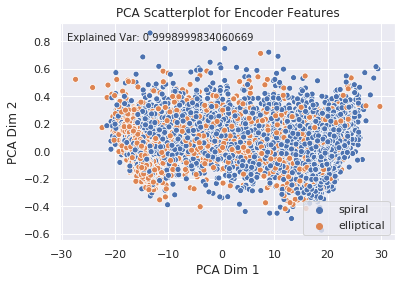

In [24]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
ax.legend(loc=4)
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')

CPU times: user 16min 31s, sys: 9.87 s, total: 16min 41s
Wall time: 13min 21s


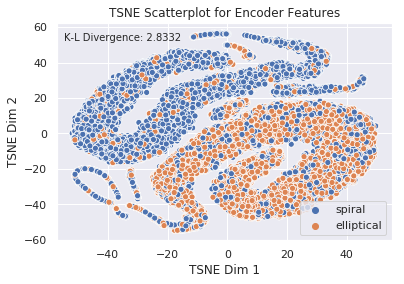

In [25]:
%%time
tsne_mod = TSNE(2)
reduced_features = tsne_mod.fit_transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'K-L Divergence: {np.round(tsne_mod.kl_divergence_, decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('TSNE Dim 1')
ax.set_ylabel('TSNE Dim 2')
ax.set_title('TSNE Scatterplot for Encoder Features')
ax.legend(loc=4)
plt.savefig(f'{results_save_dir}/TSNE_encoding_features.png')

#### Training Curves

In [26]:
dec_log, supervised_log, ptrain_log = pd.read_csv(f'{results_save_dir}/dec_log.csv'), pd.read_csv(f'{results_save_dir}/supervised_learning_log.csv'), pd.read_csv(f'{results_save_dir}/pretrain_log.csv')

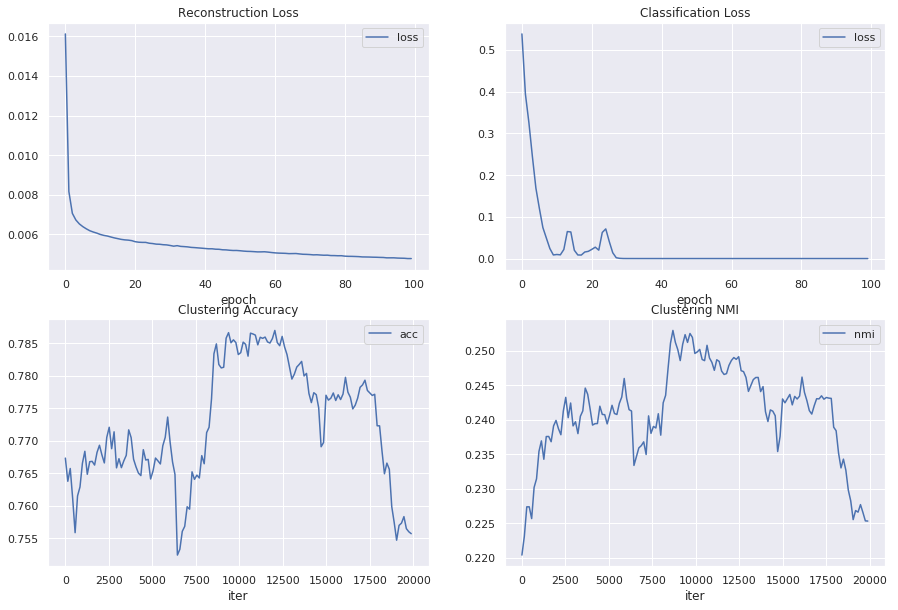

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ptrain_log.plot(x='epoch', y='loss', ax=ax[0, 0], title='Reconstruction Loss')
supervised_log.plot(x='epoch', y='loss', ax=ax[0, 1], title='Classification Loss')
dec_log.plot(x='iter', y='acc', ax=ax[1, 0], title='Clustering Accuracy')
dec_log.plot(x='iter', y='nmi', ax=ax[1, -1], title='Clustering NMI')
plt.savefig(f'{results_save_dir}/training_curves.png')

### Experiment 2: High Confidence Images of class

#### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [28]:
# Defining our DEC model
dec_model = DEC_Supervised([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [29]:
results_save_dir = 'results/high_confidence_supervised_learning_and_clustering'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [30]:
%%time
dec_model.pretrain(train_features, None, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 86us/step - loss: 0.0154
Epoch 2/100
59968/59968 [==============================] - 4s 72us/step - loss: 0.0080
Epoch 3/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0071
Epoch 4/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0063
Epoch 8/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0061
Epoch 11/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0060
Epoch 12/100
59968/5996

### Supervised Learning

#### High Confidence Galaxies training features

In [31]:
get_subdirectory_names(training_directory_path)

['spiral/', 'elliptical/']

In [32]:
high_conf_ellip_im_arr = []
for galaxy_id in high_conf_ellip_galaxies:
    image_path = construct_path(elliptical_training_directory_path, f'{galaxy_id}{image_extension}')
    high_conf_ellip_im_arr.append(image_preprocessing_function(np.array(Image.open(image_path))))
high_conf_ellip_im_arr = np.array(high_conf_ellip_im_arr)

high_conf_spiral_im_arr = []
for galaxy_id in high_conf_spiral_galaxies:
    image_path = construct_path(spiral_training_directory_path, f'{galaxy_id}{image_extension}')
    high_conf_spiral_im_arr.append(image_preprocessing_function(np.array(Image.open(image_path))))
high_conf_spiral_im_arr = np.array(high_conf_spiral_im_arr)

#### High Confidence Images Base Xception Model Features

In [33]:
%%time
# Getting the prediction
high_conf_ellip_pred = base_xception_model.predict(high_conf_ellip_im_arr)
high_conf_spiral_pred = base_xception_model.predict(high_conf_spiral_im_arr)
high_conf_pred = np.vstack((high_conf_ellip_pred, high_conf_spiral_pred))
# high_conf_label = ['Elliptical']*num_samples + ['Spiral']*num_samples
high_conf_label = [0]*num_samples + [1]*num_samples

CPU times: user 4.37 s, sys: 2.02 s, total: 6.39 s
Wall time: 6 s


In [34]:
dec_model.supervised_learning(high_conf_pred, high_conf_label, batch_size=64, epochs=100, save_dir=results_save_dir)

Learning Supervised
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.2143
Epoch 2/100
1000/1000 [==============================] - 0s 120us/step - loss: 0.0722
Epoch 3/100
1000/1000 [==============================] - 0s 115us/step - loss: 0.0251
Epoch 4/100
1000/1000 [==============================] - 0s 125us/step - loss: 0.0141
Epoch 5/100
1000/1000 [==============================] - 0s 116us/step - loss: 0.0088
Epoch 6/100
1000/1000 [==============================] - 0s 113us/step - loss: 0.0060
Epoch 7/100
1000/1000 [==============================] - 0s 115us/step - loss: 0.0040
Epoch 8/100
1000/1000 [==============================] - 0s 113us/step - loss: 0.0020
Epoch 9/100
1000/1000 [==============================] - 0s 112us/step - loss: 0.0017
Epoch 10/100
1000/1000 [==============================] - 0s 115us/step - loss: 0.0012
Epoch 11/100
1000/1000 [==============================] - 0s 114us/step - loss: 5.9077e-04
Epoch 12/100
1000/1000 [======

#### Clustering

In [35]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.72617, nmi = 0.16516, ari = 0.20455  ; loss= 0
saving model to: results/high_confidence_supervised_learning_and_clustering/DEC_model_0.h5
Iter 140: acc = 0.72777, nmi = 0.16675, ari = 0.20747  ; loss= 0.02371
Iter 280: acc = 0.73056, nmi = 0.16972, ari = 0.21259  ; loss= 0.01895
Iter 420: acc = 0.72974, nmi = 0.16896, ari = 0.21108  ; loss= 0.029
Iter 560: acc = 0.73037, nmi = 0.16913, ari = 0.21225  ; loss= 0.01721
Iter 700: acc = 0.72991, nmi = 0.16918, ari = 0.21139  ; loss= 0.01976
Iter 840: acc = 0.72619, nmi = 0.16669, ari = 0.20457  ; loss= 0.02228
Iter 980: acc = 0.72854, nmi = 0.16816, ari = 0.20887  ; loss= 0.02397
Iter 1120: acc = 0.72645, nmi = 0.16632, ari = 0.20506  ; loss= 0.0168
Iter 1260: acc = 0.72612, nmi = 0.16639, ari = 0.20445  ; loss= 0.01852
Iter 1400: acc = 0.72827, nmi = 0.16960, ari = 0.20836  ; loss= 0.01189
Iter 1540: acc = 0.73002, nmi = 0.17043, ari = 0.21159

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 7.72 s, sys: 948 ms, total: 8.66 s
Wall time: 6.59 s


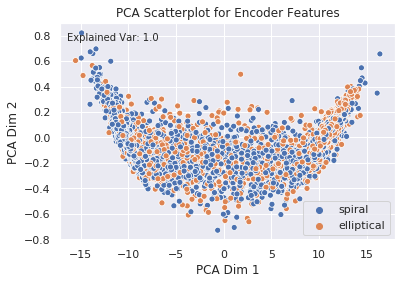

In [36]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
ax.legend(loc=4)
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')

CPU times: user 16min 49s, sys: 17.3 s, total: 17min 6s
Wall time: 13min 47s


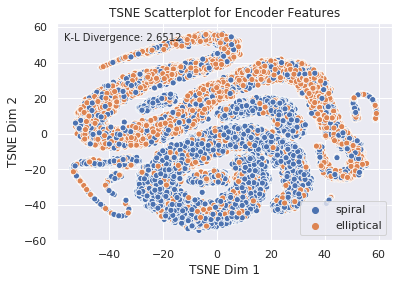

In [37]:
%%time
tsne_mod = TSNE(2)
reduced_features = tsne_mod.fit_transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'K-L Divergence: {np.round(tsne_mod.kl_divergence_, decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('TSNE Dim 1')
ax.set_ylabel('TSNE Dim 2')
ax.set_title('TSNE Scatterplot for Encoder Features')
ax.legend(loc=4)
plt.savefig(f'{results_save_dir}/TSNE_encoding_features.png')

#### Training Curves

In [38]:
dec_log, supervised_log, ptrain_log = pd.read_csv(f'{results_save_dir}/dec_log.csv'), pd.read_csv(f'{results_save_dir}/supervised_learning_log.csv'), pd.read_csv(f'{results_save_dir}/pretrain_log.csv')

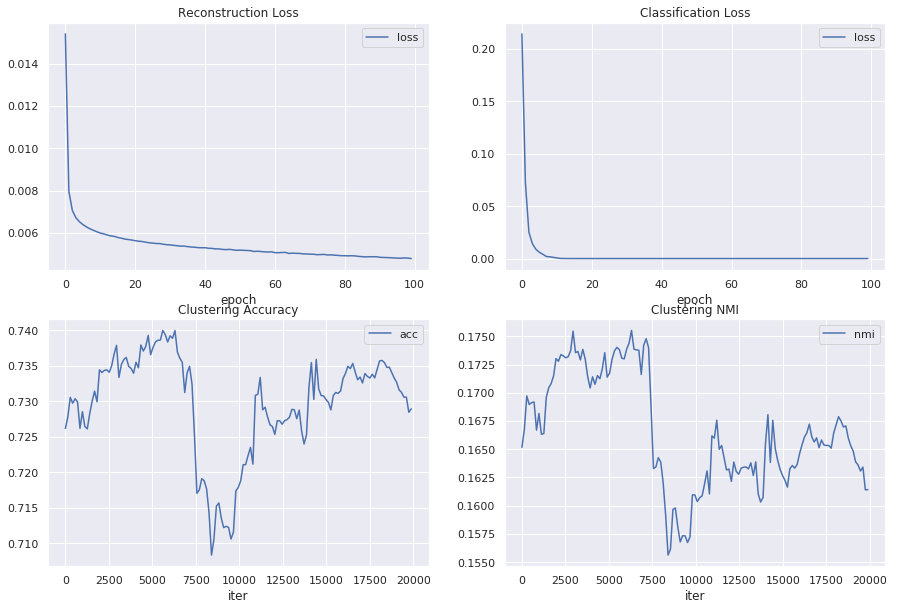

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ptrain_log.plot(x='epoch', y='loss', ax=ax[0, 0], title='Reconstruction Loss')
supervised_log.plot(x='epoch', y='loss', ax=ax[0, 1], title='Classification Loss')
dec_log.plot(x='iter', y='acc', ax=ax[1, 0], title='Clustering Accuracy')
dec_log.plot(x='iter', y='nmi', ax=ax[1, -1], title='Clustering NMI')
plt.savefig(f'{results_save_dir}/training_curves.png')

### Experiment 3: Random Images of class

#### DEC Xception Training Regime

Number of Epochs for supervised learning is much less

In [40]:
# Defining our DEC model
dec_model = DEC_Supervised([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [41]:
results_save_dir = 'results/random_supervised_learning_and_clustering_epochs_20'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [42]:
%%time
dec_model.pretrain(train_features, None, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 6s 96us/step - loss: 0.0153
Epoch 2/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0077
Epoch 3/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0070
Epoch 4/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0063
Epoch 8/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0061
Epoch 11/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0061
Epoch 12/100
59968/5996

### Supervised Learning

##### Random Sample

First we choose a random sample of images features from the dataset found and use them for the initial supervised learning

In [43]:
num_random_images = 2 * num_samples
ind = np.random.choice(range(len(train_features)), num_random_images)
random_train_features = train_features[ind]
random_train_labels = train_labels[ind]
random_train_features.shape, random_train_labels.shape

((1000, 2048), (1000,))

In [44]:
dec_model.supervised_learning(random_train_features, random_train_labels, batch_size=64, epochs=20, save_dir=results_save_dir)

Learning Supervised
Epoch 1/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.5715
Epoch 2/20
1000/1000 [==============================] - 0s 140us/step - loss: 0.4399
Epoch 3/20
1000/1000 [==============================] - 0s 133us/step - loss: 0.3656
Epoch 4/20
1000/1000 [==============================] - 0s 127us/step - loss: 0.2941
Epoch 5/20
1000/1000 [==============================] - 0s 129us/step - loss: 0.2378
Epoch 6/20
1000/1000 [==============================] - 0s 125us/step - loss: 0.1626
Epoch 7/20
1000/1000 [==============================] - 0s 125us/step - loss: 0.1080
Epoch 8/20
1000/1000 [==============================] - 0s 121us/step - loss: 0.0528
Epoch 9/20
1000/1000 [==============================] - 0s 124us/step - loss: 0.0237
Epoch 10/20
1000/1000 [==============================] - 0s 123us/step - loss: 0.0163
Epoch 11/20
1000/1000 [==============================] - 0s 120us/step - loss: 0.0184
Epoch 12/20
1000/1000 [======================

#### Clustering

In [45]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.73331, nmi = 0.21002, ari = 0.21711  ; loss= 0
saving model to: results/random_supervised_learning_and_clustering_epochs_20/DEC_model_0.h5
Iter 140: acc = 0.73396, nmi = 0.21257, ari = 0.21830  ; loss= 0.02003
Iter 280: acc = 0.73666, nmi = 0.21553, ari = 0.22343  ; loss= 0.02458
Iter 420: acc = 0.74338, nmi = 0.22172, ari = 0.23646  ; loss= 0.02149
Iter 560: acc = 0.74835, nmi = 0.22507, ari = 0.24634  ; loss= 0.02565
Iter 700: acc = 0.75188, nmi = 0.22834, ari = 0.25347  ; loss= 0.04531
Iter 840: acc = 0.75325, nmi = 0.22954, ari = 0.25625  ; loss= 0.03636
Iter 980: acc = 0.75545, nmi = 0.23318, ari = 0.26074  ; loss= 0.03817
Iter 1120: acc = 0.75128, nmi = 0.23223, ari = 0.25218  ; loss= 0.02292
Iter 1260: acc = 0.75407, nmi = 0.23461, ari = 0.25786  ; loss= 0.02866
Iter 1400: acc = 0.75364, nmi = 0.23471, ari = 0.25697  ; loss= 0.02101
Iter 1540: acc = 0.75227, nmi = 0.23371, ari = 0.2

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.36 s, sys: 540 ms, total: 6.9 s
Wall time: 5.78 s


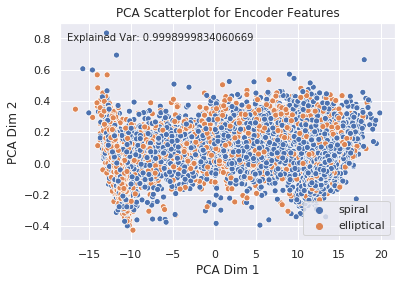

In [46]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
ax.legend(loc=4)
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')

CPU times: user 16min 55s, sys: 19.8 s, total: 17min 15s
Wall time: 13min 56s


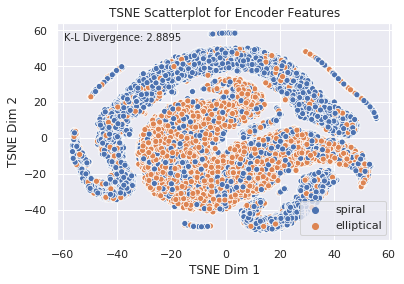

In [47]:
%%time
tsne_mod = TSNE(2)
reduced_features = tsne_mod.fit_transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'K-L Divergence: {np.round(tsne_mod.kl_divergence_, decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('TSNE Dim 1')
ax.set_ylabel('TSNE Dim 2')
ax.set_title('TSNE Scatterplot for Encoder Features')
ax.legend(loc=4)
plt.savefig(f'{results_save_dir}/TSNE_encoding_features.png')

#### Training Curves

In [48]:
dec_log, supervised_log, ptrain_log = pd.read_csv(f'{results_save_dir}/dec_log.csv'), pd.read_csv(f'{results_save_dir}/supervised_learning_log.csv'), pd.read_csv(f'{results_save_dir}/pretrain_log.csv')

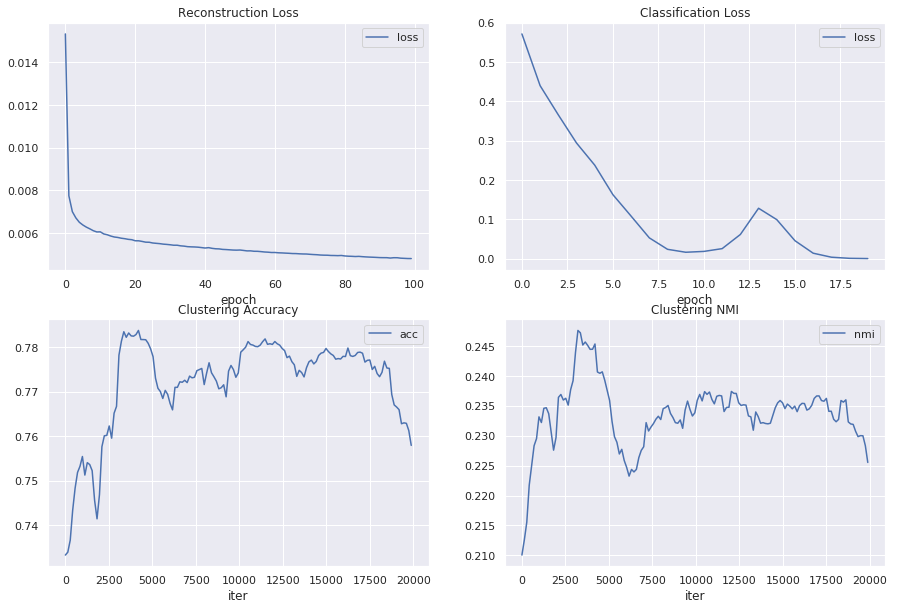

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ptrain_log.plot(x='epoch', y='loss', ax=ax[0, 0], title='Reconstruction Loss')
supervised_log.plot(x='epoch', y='loss', ax=ax[0, 1], title='Classification Loss')
dec_log.plot(x='iter', y='acc', ax=ax[1, 0], title='Clustering Accuracy')
dec_log.plot(x='iter', y='nmi', ax=ax[1, -1], title='Clustering NMI')
plt.savefig(f'{results_save_dir}/training_curves.png')

### Experiment 4: High Confidence Images of class

#### DEC Xception Training Regime

The number of epochs is 20

In [50]:
# Defining our DEC model
dec_model = DEC_Supervised([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [51]:
results_save_dir = 'results/high_confidence_supervised_learning_and_clustering_epochs_20'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [52]:
%%time
dec_model.pretrain(train_features, None, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 6s 94us/step - loss: 0.0160
Epoch 2/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0083
Epoch 3/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0071
Epoch 4/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 72us/step - loss: 0.0063
Epoch 8/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0061
Epoch 11/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0060
Epoch 12/100
59968/5996

### Supervised Learning

#### High Confidence Galaxies training features

In [53]:
get_subdirectory_names(training_directory_path)

['spiral/', 'elliptical/']

In [54]:
high_conf_ellip_im_arr = []
for galaxy_id in high_conf_ellip_galaxies:
    image_path = construct_path(elliptical_training_directory_path, f'{galaxy_id}{image_extension}')
    high_conf_ellip_im_arr.append(image_preprocessing_function(np.array(Image.open(image_path))))
high_conf_ellip_im_arr = np.array(high_conf_ellip_im_arr)

high_conf_spiral_im_arr = []
for galaxy_id in high_conf_spiral_galaxies:
    image_path = construct_path(spiral_training_directory_path, f'{galaxy_id}{image_extension}')
    high_conf_spiral_im_arr.append(image_preprocessing_function(np.array(Image.open(image_path))))
high_conf_spiral_im_arr = np.array(high_conf_spiral_im_arr)

#### High Confidence Images Base Xception Model Features

In [55]:
%%time
# Getting the prediction
high_conf_ellip_pred = base_xception_model.predict(high_conf_ellip_im_arr)
high_conf_spiral_pred = base_xception_model.predict(high_conf_spiral_im_arr)
high_conf_pred = np.vstack((high_conf_ellip_pred, high_conf_spiral_pred))
# high_conf_label = ['Elliptical']*num_samples + ['Spiral']*num_samples
high_conf_label = [0]*num_samples + [1]*num_samples

CPU times: user 3.74 s, sys: 1.71 s, total: 5.45 s
Wall time: 5.05 s


In [56]:
dec_model.supervised_learning(high_conf_pred, high_conf_label, batch_size=64, epochs=20, save_dir=results_save_dir)

Learning Supervised
Epoch 1/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.2068
Epoch 2/20
1000/1000 [==============================] - 0s 117us/step - loss: 0.0646
Epoch 3/20
1000/1000 [==============================] - 0s 115us/step - loss: 0.0257
Epoch 4/20
1000/1000 [==============================] - 0s 114us/step - loss: 0.0153
Epoch 5/20
1000/1000 [==============================] - 0s 113us/step - loss: 0.0092
Epoch 6/20
1000/1000 [==============================] - 0s 114us/step - loss: 0.0058
Epoch 7/20
1000/1000 [==============================] - 0s 113us/step - loss: 0.0041
Epoch 8/20
1000/1000 [==============================] - 0s 113us/step - loss: 9.1438e-04
Epoch 9/20
1000/1000 [==============================] - 0s 114us/step - loss: 5.1294e-04
Epoch 10/20
1000/1000 [==============================] - 0s 114us/step - loss: 5.5376e-05
Epoch 11/20
1000/1000 [==============================] - 0s 112us/step - loss: 2.0295e-05
Epoch 12/20
1000/1000 [======

#### Clustering

In [57]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.67553, nmi = 0.12610, ari = 0.12226  ; loss= 0
saving model to: results/high_confidence_supervised_learning_and_clustering_epochs_20/DEC_model_0.h5
Iter 140: acc = 0.67734, nmi = 0.12683, ari = 0.12490  ; loss= 0.03164
Iter 280: acc = 0.68206, nmi = 0.12888, ari = 0.13185  ; loss= 0.01806
Iter 420: acc = 0.68463, nmi = 0.12859, ari = 0.13575  ; loss= 0.03365
Iter 560: acc = 0.68580, nmi = 0.12889, ari = 0.13753  ; loss= 0.01637
Iter 700: acc = 0.68988, nmi = 0.13050, ari = 0.14379  ; loss= 0.02015
Iter 840: acc = 0.69235, nmi = 0.13094, ari = 0.14765  ; loss= 0.01936
Iter 980: acc = 0.69332, nmi = 0.13218, ari = 0.14915  ; loss= 0.01382
Iter 1120: acc = 0.70436, nmi = 0.13771, ari = 0.16693  ; loss= 0.0434
Iter 1260: acc = 0.70556, nmi = 0.13840, ari = 0.16892  ; loss= 0.02096
Iter 1400: acc = 0.70701, nmi = 0.13879, ari = 0.17134  ; loss= 0.01378
Iter 1540: acc = 0.70609, nmi = 0.13838, a

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.63 s, sys: 600 ms, total: 7.23 s
Wall time: 5.98 s


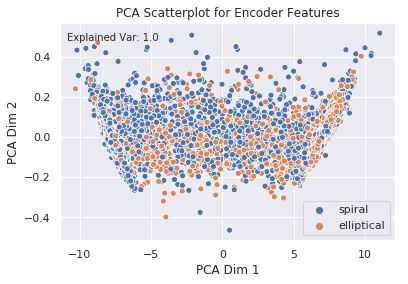

In [58]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
ax.legend(loc=4)
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')

CPU times: user 16min 32s, sys: 22.2 s, total: 16min 54s
Wall time: 13min 35s


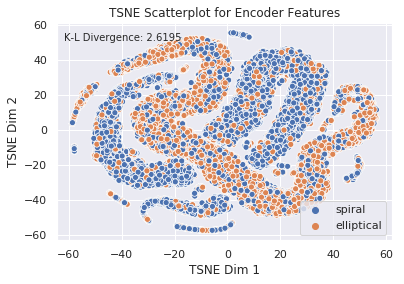

In [59]:
%%time
tsne_mod = TSNE(2)
reduced_features = tsne_mod.fit_transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'K-L Divergence: {np.round(tsne_mod.kl_divergence_, decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('TSNE Dim 1')
ax.set_ylabel('TSNE Dim 2')
ax.set_title('TSNE Scatterplot for Encoder Features')
ax.legend(loc=4)
plt.savefig(f'{results_save_dir}/TSNE_encoding_features.png')

#### Training Curves

In [60]:
dec_log, supervised_log, ptrain_log = pd.read_csv(f'{results_save_dir}/dec_log.csv'), pd.read_csv(f'{results_save_dir}/supervised_learning_log.csv'), pd.read_csv(f'{results_save_dir}/pretrain_log.csv')

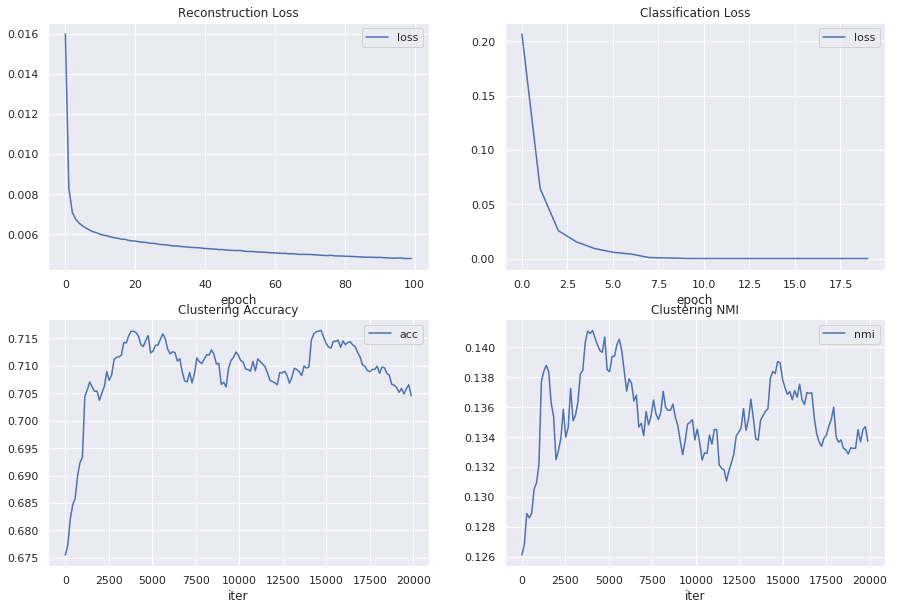

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ptrain_log.plot(x='epoch', y='loss', ax=ax[0, 0], title='Reconstruction Loss')
supervised_log.plot(x='epoch', y='loss', ax=ax[0, 1], title='Classification Loss')
dec_log.plot(x='iter', y='acc', ax=ax[1, 0], title='Clustering Accuracy')
dec_log.plot(x='iter', y='nmi', ax=ax[1, -1], title='Clustering NMI')
plt.savefig(f'{results_save_dir}/training_curves.png')